# Kenya - Loan analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#ML1">EDA.</a></li>
<li><a href="#ML2">ML.</a></li>
</ul>

***Questions will answer :*** <br>
* How are loans distributed across counties and user demographics?<br>
* Do Kenyan borrowers appear to be nationally representative?<br>
* How has the loan book evolved?<br>
* Can distinct groups of borrowers be identified?<br>
* Which factors predict who gets funded?<br>
* What data can be collected to improve monitoring and learning from loans?


<a id='intro'></a>
## Introduction

> The dataset is related to the loan details of Kenyan people in four counties, this dataset contains 614 rows each row contains data for the loan of one person so I will dig more to figure out this data and answer some questions

<a id='wrangling'></a>
## Data Wrangling


> In this section we will clarify the data to analyze it and answer the questions easily.

In [157]:
# Import the laibraies.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.model_selection import StratifiedKFold

In [158]:
# We have got an extened data
df= pd.read_csv("loan_data.xlsx - in.csv")

# describe the descriptive & continuousvalues
info,des = df.info(),df.describe()
print(info)
des

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   age                614 non-null    int64  
 3   Married            611 non-null    object 
 4   Dependents         599 non-null    object 
 5   county             614 non-null    object 
 6   Education          614 non-null    object 
 7   Self_Employed      582 non-null    object 
 8   ApplicantIncome    614 non-null    int64  
 9   CoapplicantIncome  614 non-null    float64
 10  LoanAmount         592 non-null    float64
 11  application_date   614 non-null    object 
 12  Loan_Amount_Term   600 non-null    float64
 13  Credit_History     564 non-null    float64
 14  Property_Area      614 non-null    object 
 15  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(2), o

,age,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,592.000000,600.00000,564.000000
mean,31.701954,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,8.207391,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,18.000000,150.000000,0.000000,9.000000,12.00000,0.000000
25%,25.000000,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,32.000000,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,39.000000,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,45.000000,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [159]:
df.drop(["Loan_ID"],axis=1,inplace=True)
df.describe(include="O")

,Gender,Married,Dependents,county,Education,Self_Employed,application_date,Property_Area,Loan_Status
count,601,611,599,614,614,582,614,614,614
unique,2,2,4,4,2,2,420,3,2
top,Male,Yes,0,Nairobi,Graduate,No,21/04/2018,Semiurban,Y
freq,489,398,345,170,480,500,5,233,422


There are some data need to be clean so will working on it

In [162]:
# Convert the application_date column to be date not object
df["application_date"]=pd.to_datetime(df["application_date"])

<ipython-input-162-b6e51c202c42>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df["application_date"]=pd.to_datetime(df["application_date"])


In [163]:
# fill the null values with median and mode (according there nature)
def mode(sub):
    df[sub]=df[sub].fillna(df[sub].mode()[0])

def median(sub):
    df[sub]=df[sub].fillna(df[sub].median())

In [164]:
mode("Gender"),mode("Married"),mode("Dependents"),mode("Self_Employed"),mode("Credit_History")
median("LoanAmount"),median("Loan_Amount_Term")

(None, None)

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Gender             614 non-null    object        
 1   age                614 non-null    int64         
 2   Married            614 non-null    object        
 3   Dependents         614 non-null    object        
 4   county             614 non-null    object        
 5   Education          614 non-null    object        
 6   Self_Employed      614 non-null    object        
 7   ApplicantIncome    614 non-null    int64         
 8   CoapplicantIncome  614 non-null    float64       
 9   LoanAmount         614 non-null    float64       
 10  application_date   614 non-null    datetime64[ns]
 11  Loan_Amount_Term   614 non-null    float64       
 12  Credit_History     614 non-null    float64       
 13  Property_Area      614 non-null    object        
 14  Loan_Statu

In [166]:
# Check is there any dublicates or not.
df.drop_duplicates(df,inplace=True)
df.duplicated().sum()

0

* Great, we have cleaned the data, so let's explore it (EDA)

<a id='ML1'></a>
## EDA (Exploratory Data Analysis)

### Firstly we will explore the non numeric data usind seaborn and matplotlib

In [111]:
def plot(df,column):
    # Sort the dataframe by the count of each category in descending order
    df_sorted = df[column].value_counts().sort_values(ascending=False)

    # Create a figure and axis with subplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Flatten the axis array
    ax = ax.flatten()

    # Plot countplot on the first subplot
    sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])

    # Annotate count values on the bars
    for i, v in enumerate(df_sorted):
        ax[0].text(v + 3, i, str(v), color='black', va='center')

    # Plot pie chart on the second subplot
    colors = sns.color_palette("Set2")
    ax[1].pie(x=df[column].value_counts(), labels=df[column].value_counts().index,
               colors=colors, autopct='%1.1f%%')

    # Set title for each subplot
    ax[0].set_title('Count Plot (Descending)')
    ax[1].set_title('Pie Chart')

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

<ipython-input-111-ac54d809246a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])


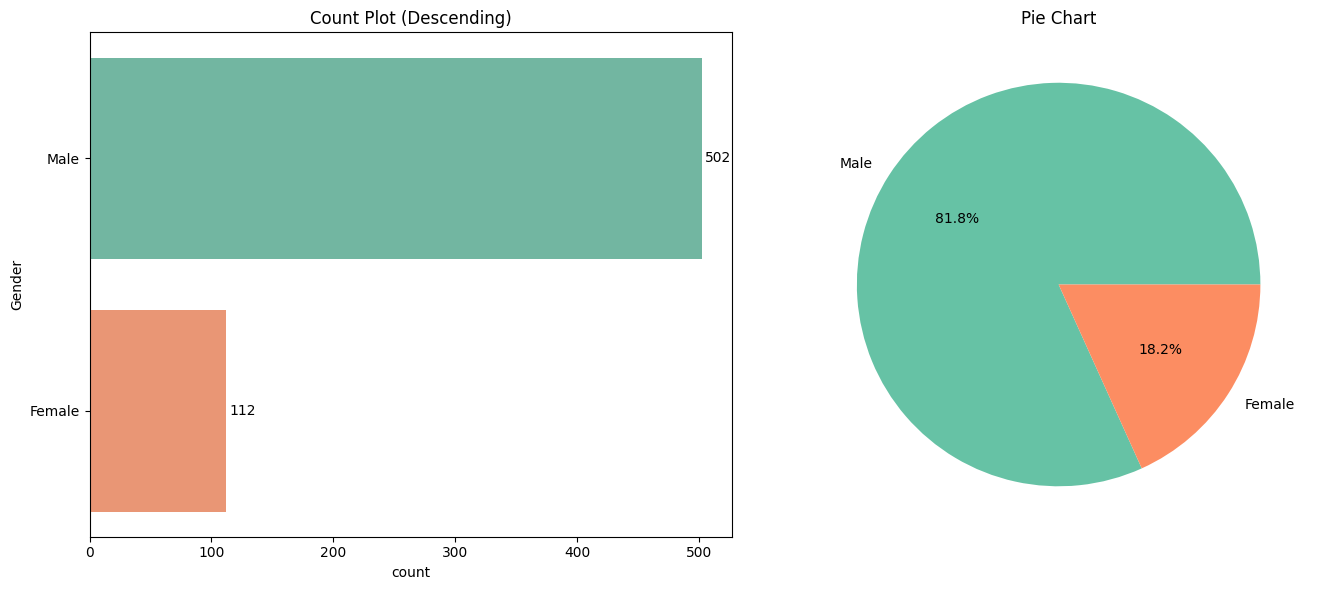

<ipython-input-111-ac54d809246a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])


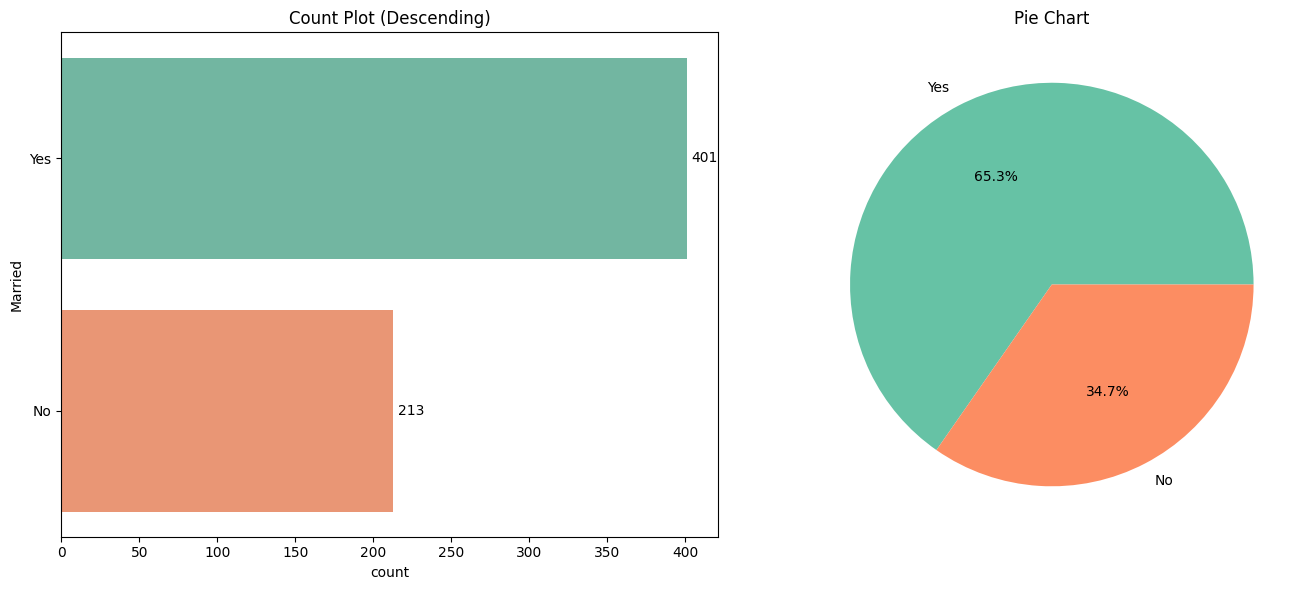

<ipython-input-111-ac54d809246a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])


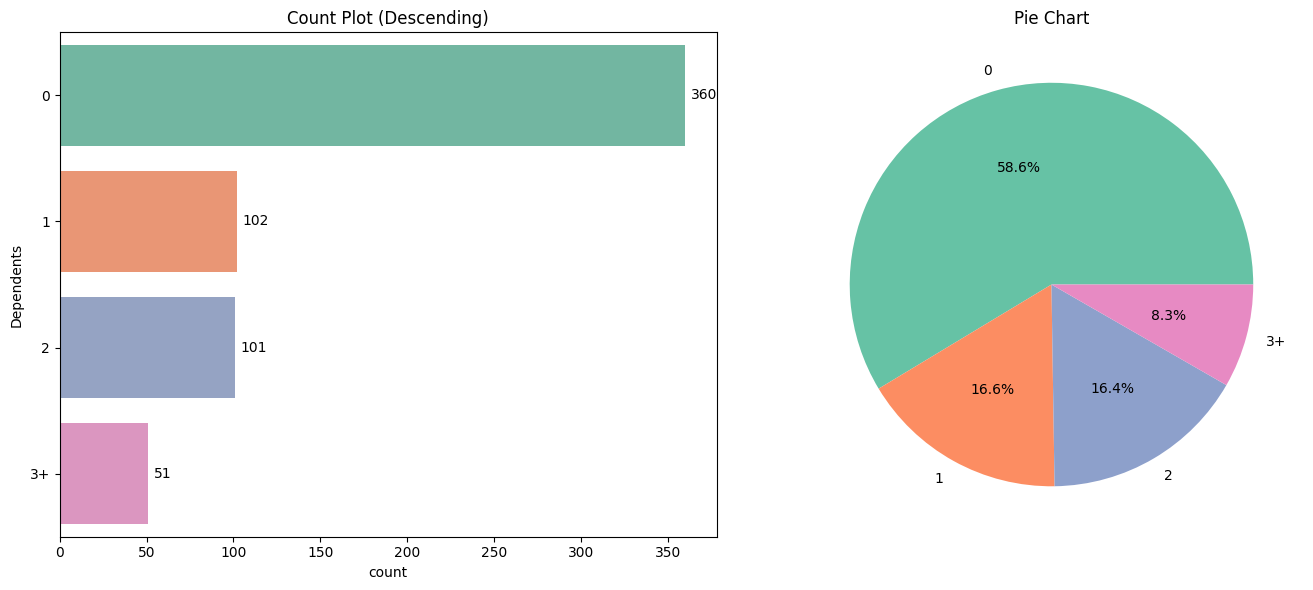

<ipython-input-111-ac54d809246a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])


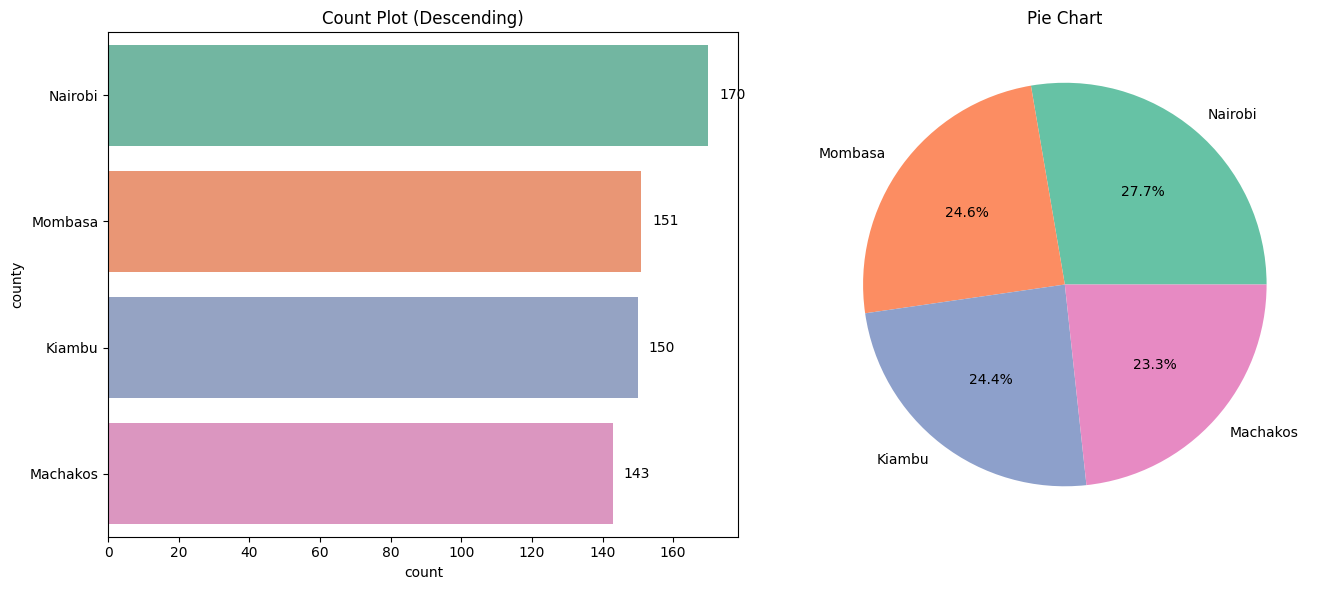

<ipython-input-111-ac54d809246a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])


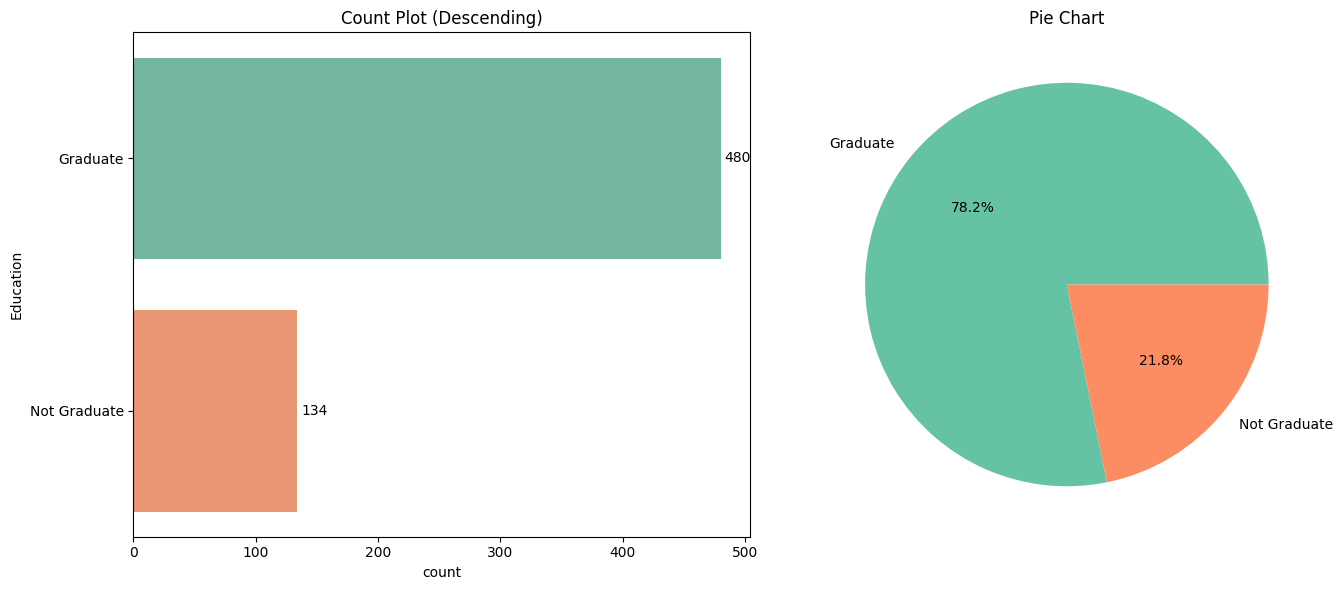

<ipython-input-111-ac54d809246a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])


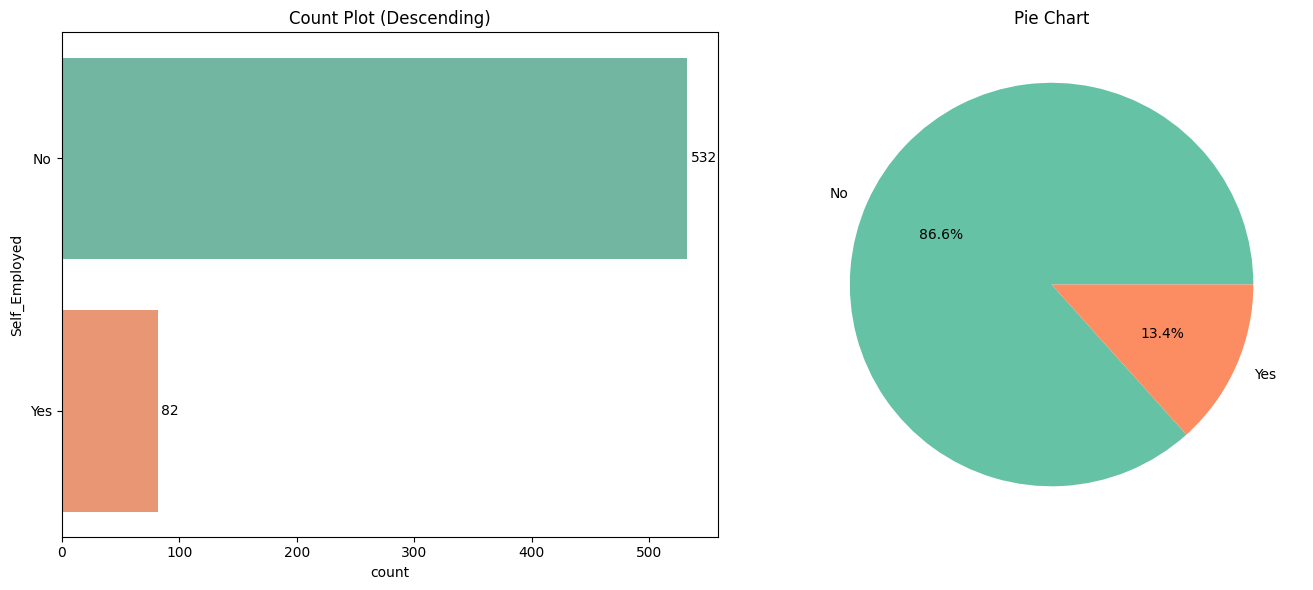

<ipython-input-111-ac54d809246a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])


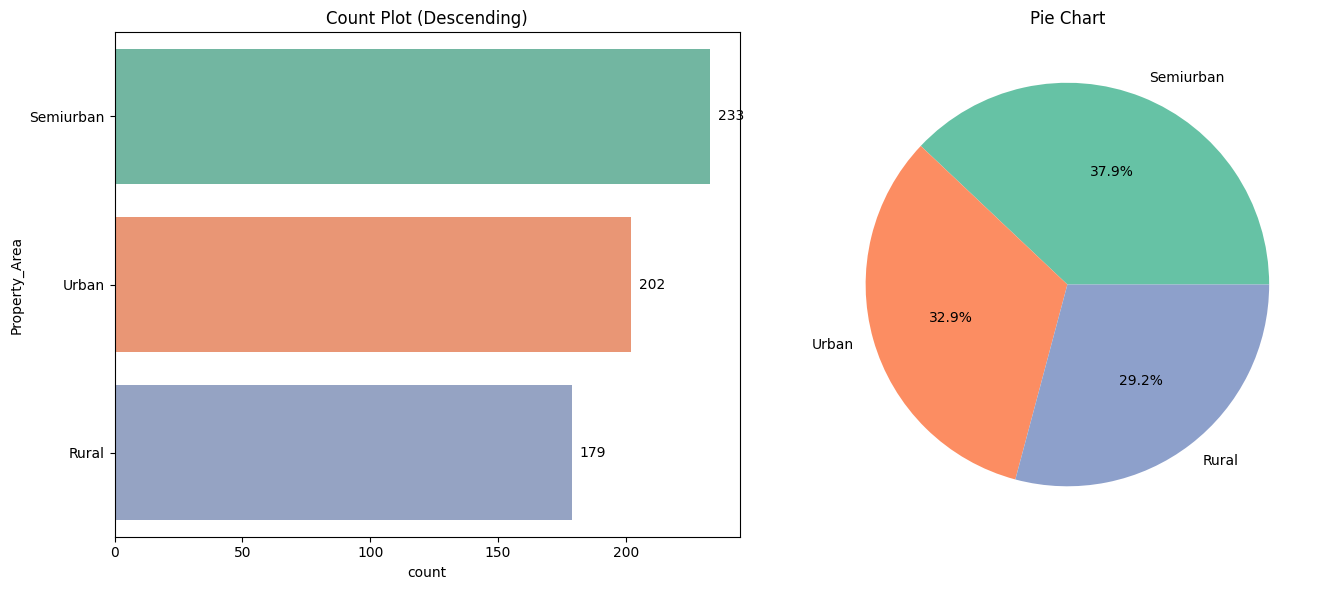

<ipython-input-111-ac54d809246a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=df_sorted.index, palette="Set2", ax=ax[0])


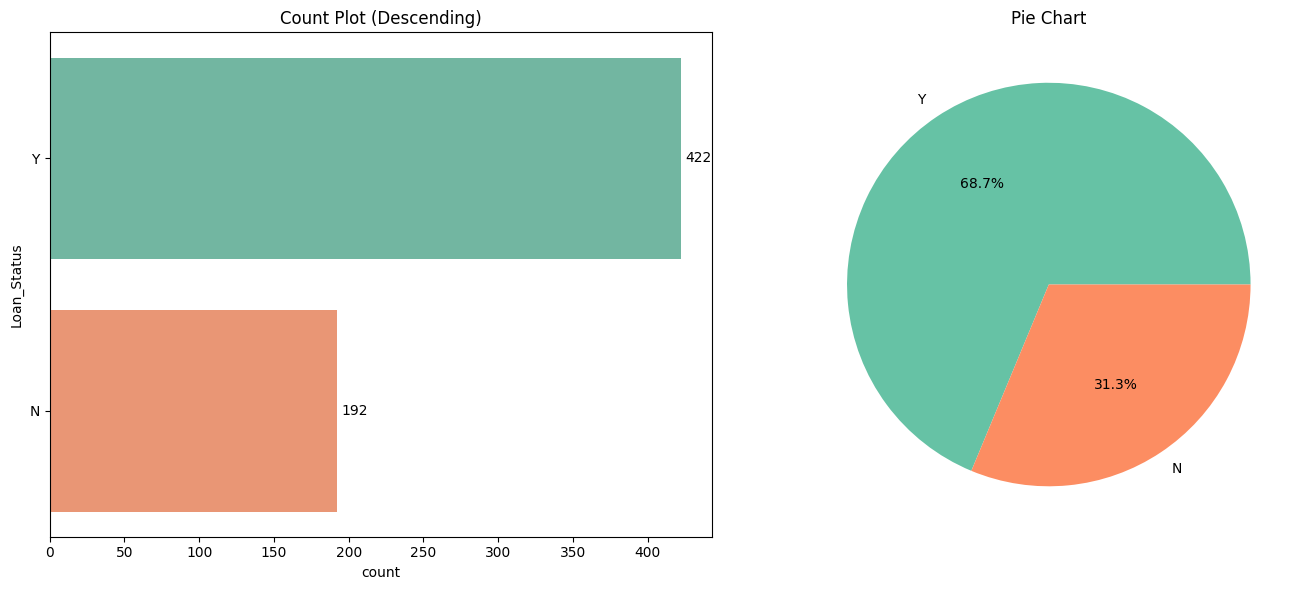

In [112]:
# Lets explore the objective data using count plot and pie chart.
for i in df.describe(include="O").columns:
    plot(df,i);

Regarding the plot above we see that the data is not qual exept in property are and country,<br> around 81% on the Gender column is male<br> 65% are Married <br>*78% Graduated and that's make sence<br>* 87% are self employed<br> 69% have a loan.

Let's answer some questions.

## How are loans distributed across counties and user demographics?

In [167]:
# Create a crosstab of loan status by county and gender
crosstab = pd.crosstab(df['county'], [df['Gender'], df['Loan_Status']])

# Print the crosstab
print(crosstab)

Gender      Female     Male    
Loan_Status      N   Y    N   Y
county                         
Kiambu           7  17   36  90
Machakos        11  24   38  70
Mombasa          8  15   35  93
Nairobi         11  19   46  94


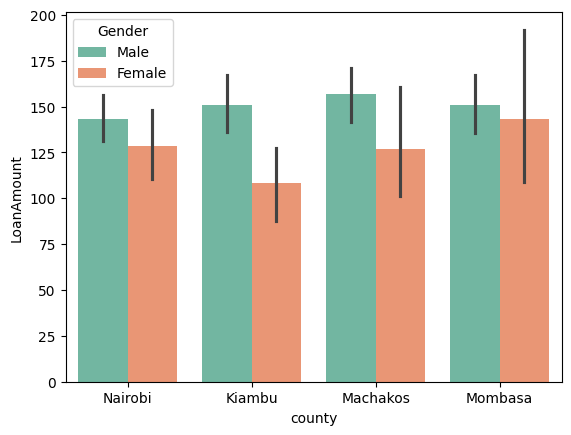

In [168]:
sns.barplot(data=df,x="county",y="LoanAmount",hue="Gender", palette="Set2");

As we see there are no significant differences in each country for taking loans as well the highest countries taken loans are Mombasa and Machakos, and we can see that the females do not take loan like a male, but we should take into consideration that the dataset that we have the percentage of the male is 81%

## Do Kenyan borrowers appear to be nationally representative?

---



In [169]:
# Here we will add a new column name it age range to give a range for each age
df1=[]
for i in df["age"]:
  if i <= 25:
    df1.append("less 26")
  elif i <= 35:
    df1.append("between 26 and 35")
  elif i <= 45:
    df1.append("between 36 and 45")
  else:
      df1.append("older 46")
df["Age_Range"]= df1

Gender            Female     Male     
Loan_Status            N   Y    N    Y
Age_Range                             
between 26 and 35     18  23   65  103
between 36 and 45     11  35   43  141
less 26                8  17   47  103


<Axes: xlabel='Age_Range', ylabel='LoanAmount'>

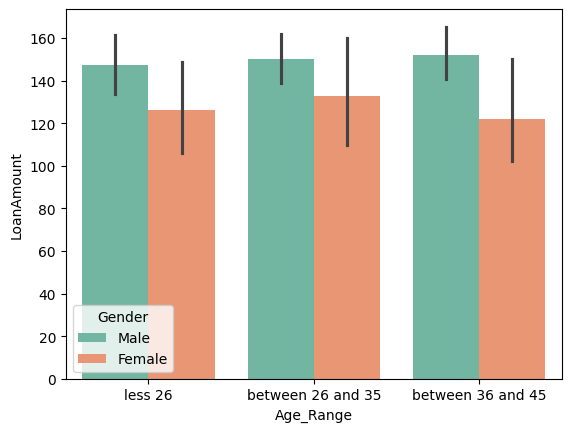

In [170]:
# Create a crosstab of loan status by age range and gender
crosstab = pd.crosstab(df['Age_Range'], [df['Gender'], df['Loan_Status']])

# Print the crosstab
print(crosstab)

sns.barplot(data=df,x="Age_Range",y="LoanAmount",hue="Gender", palette="Set2")


As we see above the age between 36 and 45 is the highest age have a loan.

# How has the loan book evolved?

In [119]:
df["loan_year"] = df["application_date"].dt.year

# Group the data by loan year and calculate the number of loans and average loan amount
grouped_data = df.groupby("loan_year").agg(
    number_of_loans=pd.NamedAgg(column="Loan_Status", aggfunc="count"),
    average_loan_amount=pd.NamedAgg(column="LoanAmount", aggfunc="mean")
)
grouped_data

,number_of_loans,average_loan_amount
loan_year,,
2017,323,141.721362
2018,291,150.226804


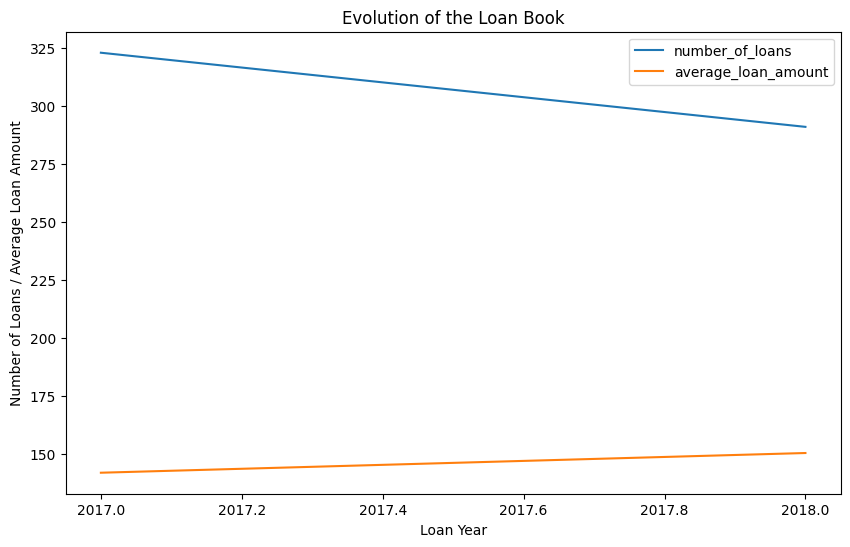

In [120]:

# Plot the number of loans and average loan amount over time
grouped_data.plot(y=["number_of_loans", "average_loan_amount"], kind="line", figsize=(10, 6))
plt.title("Evolution of the Loan Book")
plt.xlabel("Loan Year")
plt.ylabel("Number of Loans / Average Loan Amount")
plt.show()


The number of loans is decreased but the average of loans is increased.

<a id='ML2'></a>
# ML - Machine Learning


In [171]:
# Using LabelEncoder to convert all the data into numbers
LE= LabelEncoder()
for i in df[df.describe(include="O").columns]:
  df[i]=LE.fit_transform(df[i])

In [172]:
# conver the date to be number
df["month"]=df["application_date"].dt.strftime("%m").astype(int)
df["year"]=df["application_date"].dt.strftime("%Y").astype(int)
df["day"]=df["application_date"].dt.strftime("%d").astype(int)

# Which factors predict who gets funded?


In [173]:
# using lightgbm to predict the data
from lightgbm import LGBMClassifier

X=df.drop(['Loan_Status',"application_date"],axis=1).values
y=df["Loan_Status"].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LGBMClassifier(learning_rate= 0.09,verbosity= -1)
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC Score: {auc_score}")

              precision    recall  f1-score   support

           0       0.72      0.42      0.53        43
           1       0.74      0.91      0.82        80

    accuracy                           0.74       123
   macro avg       0.73      0.67      0.67       123
weighted avg       0.74      0.74      0.72       123

AUC Score: 0.6655523255813953


The AUC score is around 67% and the accurcy score around 74%, we can increase this score by getting more data and change the parameters in the model

# What data can be collected to improve monitoring and learning from loans?

* Collect more detailed information about the borrowers, such as their income, education, and employment history.
* Track the borrowers' repayment history over time.
* Conduct surveys of the borrowers to understand their needs and experiences.
* Use data analytics to identify trends and patterns in the loan data.
* Use machine learning to develop models to predict the likelihood of a borrower paying their loan.